In [1]:
import pandas as pd
from tabulate import tabulate
import numpy as np
import os
from scipy import interpolate
import matplotlib.pyplot as plt
from scipy import stats

Load and Organize Data

In [2]:
times_filename = 'usgs_full_catalog_times_cmt.txt'
extra_info_filename = "usgs_full_catalog_M5_info.txt"
main_event_times_filename = 'usgs_full_catalog_M5_times.txt'
main_events_filename = 'usgs_full_catalog_M5.csv'
times_original = np.loadtxt(times_filename, dtype = str)
times_dt64 = []

for i in times_original:
    times_dt64.append(np.datetime64(i[0]+'T'+i[1])) # Convert times to numpy datetime64
grand_times = np.array(times_dt64)
extra_info = np.loadtxt(extra_info_filename,dtype = object)

main_events = np.loadtxt(main_events_filename,skiprows = 1, delimiter = ',')
main_times_original = np.loadtxt(main_event_times_filename, dtype = str)
times_dt64_2 = []

for i in main_times_original:
    times_dt64_2.append(np.datetime64(i)) # Convert times to numpy datetime64
main_event_times = np.array(times_dt64_2)

r_list = [0.25,0.5,0.75,1,2,3,4,7,15,30,45,60,90,120,150,180,365,730,1095]

In [3]:
# Since we only want M6+ events here, we need to uncouple M6 mainshocks from any M5 foreshocks
for i in range(len(main_event_times)):
    if extra_info[i,1] == 'yes' and extra_info[i,0] != 'third':
        if main_events[i,3] < 6.0:
            extra_info[i+1,0] = 'first'
            extra_info[i+1,1] = 'no'
    elif extra_info[i,0] == 'third':
        extra_info[i,0] = 'first'
        extra_info[i,1] = 'no'


In [4]:
def calculate_MatthewsC(P,S):
    """calculate the matthews correlation coefficient.
    Expects a vector of predictions P and observations S.
    The values in P and S.
    P=0 means no larger earthquake earthquake
    P=1 means that we predict a larger earthquake
    P=.05 means 1/20 chance of a larger earthquake"""
    assert(np.shape(S) == np.shape(P))
    sbar = np.mean(S)
    pbar = np.mean(P)
    if pbar == 0 or sbar == 0 or np.std(S) == 0 or np.std(P) == 0:
        return 0
    numerator = np.sum((S-sbar)*(P-pbar))
    denominator = (np.sum((S-sbar)**2)*np.sum((P-pbar)**2))**0.5
    C = numerator/denominator
    return C
    
def calculate_accuracy(grand_times,csv_data,r_current,extra_info,main_event_times,main_events,r_list,pair_matrix,index,verbose=False,default_prob=.9):
    ''' Function takes the results with equivalent end times for a certain parameter combination, determines the 
    sucsess of the TLS score, counts the confusion matrix, and converts to the different success measures. This is repeated for each
    alert threshold within this function, so the output is 5 values for each statistic (f1_list,f2_list,etc), their corresponding confusion
    matricies (conf_list), and the results for each earthquake pair (pair matrix)
    Inputs are the grand_times = complete time data, the csv file for a particular parameter combination = csv_data,
    end time of interest = r_current, the matrix containing event relationships based off the GK window (extra_info),
    times of M5+ events (main_event_times), M5+ catalog (main_events), list of all end times (r_list), and the
    index corresponding to the csv file so that the results are organized correctly.
    default_prob=.9 this is the default probability that an event is a mainshock.'''
    r_ind = r_list.index(r_current)
    percent_change_column = csv_data.iloc[:,8+(9*r_ind)]
    cat_end_time = np.max(grand_times) # Latest Time in the Catalog
    magnitude_interp = np.arange(2.5,8.5,0.5)
    time_function = interpolate.interp1d(magnitude_interp,np.array([6,11.5,22,42,83,155,290,510,790,915,960,985])) #GK time window
    f1_list = []
    f2_list = []
    ba_list = []
    C_list = []
    ktb_list = []
    conf_list = [] # Confusion Matrix
    new_index = np.copy(index)
    for threshold in [5,10,15,20,25]:
        true_predict = 0 # True Positives, Correct Predictions
        true_nonpredict = 0 # True Negatives, Correct Non-Predictions
        false_predict = 0 # False Negatives, False Predictions
        failed_to_predict = 0 # False Positives, 2nd Event occured with no prediction
        neutral = 0
        early = 0
        insuff = 0
        post_gk_deadline = 0 # Events for which this end-time is past the end of the GK Window
        post_second_event_deadline = 0 # Events for which this end-time is past the mainshock is the event is the first earthquake in a foreshock-mainshock pair
        prediction_list = []
        observation_list = []
        if r_current == 0.25:
            r_datetime = np.timedelta64(6,'h')
        elif r_current == 0.5:
            r_datetime = np.timedelta64(12,'h')
        elif r_current == 0.75:
            r_datetime = np.timedelta64(18,'h')
        else:
            r_datetime = np.timedelta64(r_current,'D')
        pair_event = 0
        for i in range(len(percent_change_column)): # Loop through the results for each event
            if main_events[i,3] < 6.0: # Only conduct the analysis on M6+ events
                continue
            if cat_end_time < main_event_times[i] + np.timedelta64(int(time_function(main_events[i,3])),'D'):
                # Check if time of catalog download is earlier than the GK end time, if not continue
                last_r = float(csv_data.iloc[i,-10]) # Obtain the final end time that has a score
                if last_r < int(time_function(main_events[i,3])): # If the GK window has passed, proceed
                    pass
                else:
                    # If not, the event is considered too recent to judge
                    early += 1
                    key = 'E'
                    if extra_info[i,1] == 'yes':
                        pair_matrix[new_index,pair_event] = key
                        pair_event += 1
                    continue
            Event_of_interest = extra_info[i,0]
            second_quake_exsists = extra_info[i,1]
            if main_events[i,3] < 6.0: # Set alert-boundaries via the alert threshold
                yg = np.copy(threshold) 
                yr = -np.copy(threshold)
            else:
                yg = 10
                yr = -10
            percent_change = percent_change_column[i]
            if percent_change == 'None': # Check if a score was generated
                last_r = float(csv_data.iloc[i,-10]) # Obtain the final end time that has a score
                if last_r < r_current: # Check if the final meaningful end time occurred before the current end time
                    prediction_list.append(default_prob)
                    if Event_of_interest == 'first' and second_quake_exsists == 'yes':
                        post_second_event_deadline += 1
                        observation_list.append(0)#1=mainshock 0=foreshock
                        key = 'I-2' # Insufficient Data - this time step is after a second event already occurred, the threat has passed
                    else:
                        post_gk_deadline += 1
                        observation_list.append(1)#1=mainshock 0=foreshock
                        key = 'I-GK' # Insufficient Data - current time is after the GK window, the threat has passed
                else:
                    insuff += 1
                    key = 'I' # Insufficient Data - Code could not generate a score
                    prediction_list.append(default_prob)
                    if second_quake_exsists == 'yes' and Event_of_interest == 'first':
                        observation_list.append(0)#1=mainshock 0=foreshock
                    else:
                        observation_list.append(1)#1=mainshock 0=foreshock
            else: #For events that do have scores, the following determines the confusion matrix
                percent_change = float(percent_change)
                if Event_of_interest == 'first':
                    if percent_change >= yg: #Green Alert
                        if second_quake_exsists == 'yes' and Event_of_interest == 'first':
                            failed_to_predict += 1
                            key = 'FTP'
                            prediction_list.append(1) #1=mainshock 0=foreshock
                            observation_list.append(0)#1=mainshock 0=foreshock
                        else:
                            true_nonpredict += 1
                            key = 'TNP'
                            prediction_list.append(1) #1=mainshock 0=foreshock
                            observation_list.append(1)#1=mainshock 0=foreshock
                    elif percent_change <= yr: # Red Alert
                        if second_quake_exsists == 'yes' and Event_of_interest == 'first':
                            true_predict += 1
                            key = 'TP'
                            prediction_list.append(0) #1=mainshock 0=foreshock
                            observation_list.append(0)#1=mainshock 0=foreshock
                        else:
                            false_predict += 1
                            key = 'FP'
                            prediction_list.append(0) #1=mainshock 0=foreshock
                            observation_list.append(1)#1=mainshock 0=foreshock
                    else: # Yellow Alert
                        neutral += 1
                        key = 'N'
                        prediction_list.append(default_prob) # probability that this is a foreshock
                        if second_quake_exsists == 'yes' and Event_of_interest == 'first':
                            observation_list.append(0)
                        else:
                            observation_list.append(1)
                else:
                    if percent_change >= yg: # Green Alert
                        prediction_list.append(1)#1=mainshock 0=foreshock
                        if second_quake_exsists == 'yes' and Event_of_interest == 'first':
                            failed_to_predict += 1
                            key = 'FTP'
                            observation_list.append(0)#1=mainshock 0=foreshock
                        else:
                            true_nonpredict += 1
                            key = 'TNP'
                            observation_list.append(1)#1=mainshock 0=foreshock
                    elif percent_change <= yr: # Red Alert
                        prediction_list.append(0)#1=mainshock 0=foreshock
                        if second_quake_exsists == 'yes' and Event_of_interest == 'first':
                            true_predict += 1
                            key = 'TP'
                            observation_list.append(0)#1=mainshock 0=foreshock
                        else:
                            false_predict += 1
                            key = 'FP'
                            observation_list.append(1)#1=mainshock 0=foreshock
                    else: # Yellow Alert 
                        neutral += 1
                        key = 'N'
                        prediction_list.append(default_prob)
                        if second_quake_exsists == 'yes' and Event_of_interest == 'first':
                            observation_list.append(0)
                        else:
                            observation_list.append(1)
            if extra_info[i,1] == 'yes':  # If the event is a foreshock-mainshock pair, add it to the pair matrix
                pair_matrix[new_index,pair_event] = key
                pair_event += 1
        prediction_list = np.array(prediction_list)
        observation_list = np.array(observation_list)
        candidate_tp = len(observation_list) - np.count_nonzero(observation_list) # True number of foreshocks
        C = calculate_MatthewsC(prediction_list,observation_list)
        ktb = stats.kendalltau(x=prediction_list,y=observation_list)[0]
        
        if verbose:
            print('\nThreshold = ',threshold)                 
            print('Number of Successful Predictions:',true_predict)
            print('Number of Successful Non-Predictions:',true_nonpredict)
            print('Number of Incorrect Predictions:',false_predict)
            print('Number of Fail to Predicts:',failed_to_predict)
            print('Number of Neutral Results:',neutral)
            print('Too Early to Call:',early)
            print('Total Events post-GK Cutoff:',post_gk_deadline)
            print('Total Events post-2nd Event Cutoff:',post_second_event_deadline)
            print('Total Events with Insufficient Data:',insuff)
            print('Matthews C:',C)
            print('Total:',true_predict+true_nonpredict+false_predict+failed_to_predict+neutral+early+post_gk_deadline+post_second_event_deadline+insuff)
        conf_list.append([true_predict,true_nonpredict,false_predict,failed_to_predict,neutral,early,post_gk_deadline+post_second_event_deadline+insuff])
        
        # Calculate F-score with beta = 2
        beta = 2
        if true_predict == 0 and false_predict == 0 and failed_to_predict == 0:
            f_2 = 0.0
        else:
            f_2 = (((1+beta**2)*true_predict) / (((1+beta**2)*true_predict) + (((((beta**2)*((len(observation_list)-candidate_tp)-true_nonpredict))+(candidate_tp-true_predict))))))
        f2_list.append(f_2)
        # Calculate F-score with beta = 1
        beta = 1
        if true_predict == 0 and false_predict == 0 and failed_to_predict == 0:
            f_1 = 0.0
        else:
            f_1 = (((1+beta**2)*true_predict) / (((1+beta**2)*true_predict) + (((((beta**2)*((len(observation_list)-candidate_tp)-true_nonpredict))+(candidate_tp-true_predict))))))
        f1_list.append(f_1)
        # Calculate Balanced Accuracy
        if (true_predict + failed_to_predict) == 0 or (true_nonpredict + false_predict) == 0:
            ba = 0.0
        else:
            tp_rate = true_predict / candidate_tp
            tn_rate = true_nonpredict / (len(observation_list)-candidate_tp)
            ba = (tp_rate+tn_rate) / 2
        ba_list.append(ba)
        C_list.append(C)
        ktb_list.append(ktb)
        new_index += 1
    return conf_list, pair_matrix, f2_list, f1_list, ba_list, C_list, ktb_list

Result Matrix

Col 0: MCC

Col 1: start time

Col 2: no alert time

Col 3: precut magnitude

Col 4: distance threshold

Col 5: alert threshold

Col 6: end time

Col 7: F1

Col 8: F2

Col 9: Balanced Average

Col 10: Kendall Tau Beta

Confusion Matrix:

Col 0: True Predictions (TP)

Col 1: True Non-predictions (TNP)

Col 2: False Predict (FP)

Col 3: Fail to Predict (FTP)

Col 4: Neutral (N)

Col 5: Early (E)

Col 6: Insufficient (Ins)

In [5]:
r_list_mod = [0.25,0.5,0.75,1,2,3,4,7,15,30,45,60,90,120,150,180,365,730]
n = 720 * len(r_list_mod) * 5 # Number of unique parameter combinations
result_matrix = np.empty((n,11)) # Initialize matrix to hold parameter combinations and statistial scores,
conf_matrix = np.empty((n,7)) # Initialize matrix to hold the confusion matrix results 
pair_matrix = np.empty((n,np.count_nonzero(extra_info[:,1] == 'yes')),dtype=object) # Initialize matrix to hold the confusion matrix result for the mainshock-foreshock pairs
index = 0
verbose = False
for filename in os.listdir():
    if filename.startswith('st'):
        csv_data = pd.read_csv(filename,dtype=str)
        fields = filename[:-4].split('_') # Extract the parameter combination from the file name
        fields = [j.replace('Auto','-1') for j in fields]
        for r in r_list_mod: # Loop through each time step
            if verbose:
                print('Time Step:',r)
            conf_values, pair_matrix, f2_list, f1_list, ba_list, C_list, ktb_list = calculate_accuracy(grand_times,csv_data,r,extra_info,main_event_times,main_events,r_list,pair_matrix,index,verbose=False)
            for count,i in enumerate(C_list):
                # Populate result_matrix with the statistical scores and parameter combinations
                result_matrix[index,0] = i
                result_matrix[index,1] = fields[1]
                result_matrix[index,2] = fields[3]
                result_matrix[index,3] = fields[5]
                result_matrix[index,4] = fields[7]
                result_matrix[index,6] = r
                result_matrix[index,7] = f2_list[count]
                result_matrix[index,8] = f1_list[count]
                result_matrix[index,9] = ba_list[count]
                result_matrix[index,10] = ktb_list[count]
                # Populate the conf_matrix with the confusion matrix values
                conf_matrix[index,0] = conf_values[count][0]
                conf_matrix[index,1] = conf_values[count][1]
                conf_matrix[index,2] = conf_values[count][2]
                conf_matrix[index,3] = conf_values[count][3]
                conf_matrix[index,4] = conf_values[count][4]
                conf_matrix[index,5] = conf_values[count][5]
                conf_matrix[index,6] = conf_values[count][6]
                # Adding the alert threshold to the result_matrix
                if count == 0:
                    result_matrix[index,5] = 5
                elif count == 1:
                    result_matrix[index,5] = 10
                elif count == 2:
                    result_matrix[index,5] = 15
                elif count == 3:
                    result_matrix[index,5] = 20
                else:
                    result_matrix[index,5] = 25
                index += 1                
                

In [6]:
print(np.max(result_matrix[:,0])) # Maximum MCC
print(np.max(result_matrix[:,7])) # Maximum f2-score
print(np.max(result_matrix[:,8])) # Maximum f1-score
print(np.max(result_matrix[:,9])) # Maximum Balanced Accuracy
print(np.nanmax(result_matrix[:,10])) # Maximum Kendalls Tau

0.5078910917958558
0.11904761904761904
0.16666666666666666
0.3092105263157895
0.46466018864229247


Histogram of Matthews Correlation Coefficient

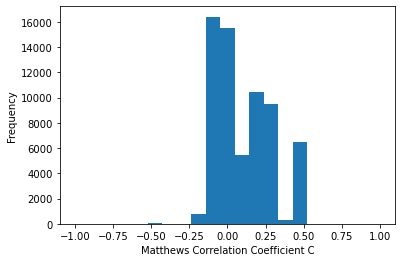

In [7]:
C_master_list = np.copy(result_matrix[:,0])
plt.hist(C_master_list,bins=21,range=(-1,1))
plt.xlabel('Matthews Correlation Coefficient C')
plt.ylabel('Frequency')
plt.show()

Histogram of Kendall's Tau Beta Correlation Coefficient

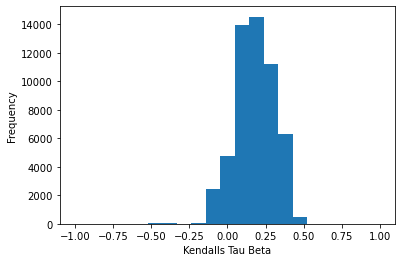

In [8]:
ktb_master_list = np.copy(result_matrix[:,10])
plt.hist(ktb_master_list,bins=21,range=(-1,1))
plt.xlabel('Kendalls Tau Beta')
plt.ylabel('Frequency')
plt.show()

In [9]:
# M6 does not have a variable distance or alert threshold, so the results have duplicates. This removes the duplicates
new_result_matrix = np.empty((0,11))
new_conf_matrix = np.empty((0,7))
new_pairs_matrix = np.empty((0,23))
duplicate_index = 0
for st in [1971,15,20,-1,10,5]:
    for na in [0.05,0.1,0.5,1,-1]:
        for pc in [-1,1.5,1,2]:
            for r in r_list_mod:
                for row_index,row in enumerate(result_matrix):
                    if row[1] == st and row[2] == na and row[3] == pc and row[6] == r:
                        new_result_matrix = np.vstack((new_result_matrix,row))
                        new_conf_matrix = np.vstack((new_conf_matrix,conf_matrix[row_index,:]))
                        new_pairs_matrix = np.vstack((new_pairs_matrix,pair_matrix[row_index,:]))
                        break

To sort by MCC, use index = 0 below

f2 use index = 7

f1, index = 8

balanced average, index = 9

Kendall's Tau, index=10

In [10]:
result_matrix = np.copy(new_result_matrix)
conf_matrix = np.copy(new_conf_matrix)
pair_matrix = np.copy(new_pairs_matrix)
for i in range(len(result_matrix[:,10])):
    if np.isnan(result_matrix[i,10]) == True:
        result_matrix[i,10] = -2 # Removing nans because argsort() is ranking nans the highest

index=0
sorted_array = result_matrix[result_matrix[:,index].argsort()]
sorted_matrix = conf_matrix[result_matrix[:,index].argsort()]
sorted_pairs = pair_matrix[result_matrix[:,index].argsort()]

In [11]:
headers = ['C','Start Time','No Alert Time (days)','Precut Magnitude','End Time (days)','F2','F1','BA','KTB']
table = tabulate(sorted_array[-12:,[0,1,2,3,6,7,8,9,10]],headers=headers,tablefmt='simple',floatfmt='.3f')
print(table)

    C    Start Time    No Alert Time (days)    Precut Magnitude    End Time (days)     F2     F1     BA    KTB
-----  ------------  ----------------------  ------------------  -----------------  -----  -----  -----  -----
0.508        15.000                   0.500               1.500             30.000  0.089  0.118  0.309  0.407
0.508        15.000                   0.500               1.500             60.000  0.089  0.118  0.309  0.407
0.508        15.000                   0.500               1.000             60.000  0.089  0.118  0.309  0.407
0.508      1971.000                   0.500               1.500             60.000  0.089  0.118  0.309  0.407
0.508        -1.000                   0.500               1.500             30.000  0.089  0.118  0.309  0.407
0.508        10.000                   0.500               1.500             60.000  0.089  0.118  0.309  0.407
0.508        20.000                   0.500               1.500             60.000  0.089  0.118  0.309  0.407
0

In [12]:
headers1 = ['TP','TNP','FP','FTP','N','E','Ins']
table1 = tabulate(sorted_matrix[-12:,:],headers=headers1,tablefmt='simple')
print(table1)

  TP    TNP    FP    FTP    N    E    Ins
----  -----  ----  -----  ---  ---  -----
   1      7     0      0    2    3     13
   1      7     0      0    3    3     12
   1      7     0      0    5    3     10
   1      7     0      0    3    3     12
   1      7     0      0    2    3     13
   1      7     0      0    3    3     12
   1      7     0      0    3    3     12
   1      7     0      0    3    3     12
   1      7     0      0    2    3     13
   1      7     0      0    2    3     13
   1      7     0      0    6    3      9
   1      7     0      0    2    3     13


In [13]:
headers = ['C','Start Time','No Alert Time (days)','Precut M','End Time (days)','TP','TNP','FP','FTP','N','E','Ins','F2','F1','BA','KTB']
table = tabulate(np.concatenate([sorted_array[-12:,[0,1,2,3,6]],sorted_matrix[-12:,:],sorted_array[-12:,[7,8,9,10]]],axis=-1),headers=headers,tablefmt='simple',floatfmt=(".3f",'.0f','.1f','.1f','.0f','.0f','.0f','.0f','.0f','.0f','.0f','.0f',".3f",".3f",".3f",".3f"))

print(table)

    C    Start Time    No Alert Time (days)    Precut M    End Time (days)    TP    TNP    FP    FTP    N    E    Ins     F2     F1     BA    KTB
-----  ------------  ----------------------  ----------  -----------------  ----  -----  ----  -----  ---  ---  -----  -----  -----  -----  -----
0.508            15                     0.5         1.5                 30     1      7     0      0    2    3     13  0.089  0.118  0.309  0.407
0.508            15                     0.5         1.5                 60     1      7     0      0    3    3     12  0.089  0.118  0.309  0.407
0.508            15                     0.5         1.0                 60     1      7     0      0    5    3     10  0.089  0.118  0.309  0.407
0.508          1971                     0.5         1.5                 60     1      7     0      0    3    3     12  0.089  0.118  0.309  0.407
0.508            -1                     0.5         1.5                 30     1      7     0      0    2    3     13  0.089

Result Table for the 4 candidate earthquake pairs

In [14]:
headers2 = ['SH1','SH2','CM1','CM2','JT','Lan','Rid1','Rid2']
table2 = tabulate(sorted_pairs[-12:,:8],headers=headers2,tablefmt='simple')
print(table2)

SH1    SH2    CM1    CM2    JT    Lan    Rid1    Rid2
-----  -----  -----  -----  ----  -----  ------  ------
I-2    I      I      I      TP    TNP    I-2     E
I-2    I      I      I      TP    TNP    I-2     E
I-2    I      I      TNP    TP    TNP    I-2     E
I-2    I      I      I      TP    TNP    I-2     E
I-2    I      I      I      TP    TNP    I-2     E
I-2    I      I      I      TP    TNP    I-2     E
I-2    I      I      I      TP    TNP    I-2     E
I-2    I      I      I      TP    TNP    I-2     E
I-2    I      I      I      TP    TNP    I-2     E
I-2    I      I      I      TP    TNP    I-2     E
I-2    I      I      TNP    TP    TNP    I-2     E
I-2    I      I      I      TP    TNP    I-2     E


In [15]:
# Determine indicies of events that ever have a True Prediction
col_list = []
for row in range(len(sorted_pairs[:,0])):
    for col in range(len(sorted_pairs[0,:])):
        if sorted_pairs[row,col] == 'TP':
            if col not in col_list:
                col_list.append(col)
print(col_list) # So only ever get Landers and Ridgecrest

[6, 4]


### Check Time Variability

This cycles through every parameter combination, and considers each individual earthquake to determine how the alert level changes with end time.

In [16]:
# Initialize counts of all possibilities
g_r = 0 # Changes between green and red, vice versa
r_y = 0 # Between red and yellow, vice versa
g_y = 0 # Between green and yellow, vice versa
g_all = 0 # Always green
y_all = 0 # Always red
r_all = 0 # Always red
i_all = 0 # Always insufficient
csv_count = 0
M6_count = 0
for st in ['1971','15.0','20.0','Auto','10.0','5.0']: # Need to specify parameters to avoid duplicate csvs
    for na in ['0.05','0.1','0.5','1.0','Auto']:
        for pc in ['Auto','1.5','1.0','2.0']:
            for filename in os.listdir():
                if filename == 'st_'+st+'_na_'+na+'_pm_'+pc+'_dt_1.0.csv':
                    csv_count += 1
                    csv_data = pd.read_csv(filename,dtype=str)
                    i_list = []
                    for i in range(len(csv_data.iloc[:,0])):
                        row = csv_data.iloc[i,:]
                        if float(row[1]) < 6:
                            continue
                        M6_count += 1
                        # Initialize a set of keys to mark colors at previous time steps
                        red_permanent_key = False # Permanent keys are turned on if the color ever appears, and do not get overwritten
                        green_permanent_key = False
                        yellow_permanent_key = False
                        red_key = False # These keys are overwritten at every end time
                        green_key = False
                        yellow_key = False
                        for time_index in range(len(r_list_mod)):
                            percent_change = row[8+(9*time_index)]
                            if percent_change != 'None':
                                percent_change = float(percent_change)
                                if percent_change <= -10:
                                    red_key = True
                                elif percent_change >= 10:
                                    green_key = True
                                else:
                                    yellow_key = True
                                if red_permanent_key == False:
                                    if red_key == True:
                                        red_permanent_key = True
                                if green_permanent_key == False:
                                    if green_key == True:
                                        green_permanent_key = True
                                if yellow_permanent_key == False:
                                    if yellow_key == True:
                                        yellow_permanent_key = True
                        if (green_permanent_key == True) and (yellow_permanent_key == False) and (red_permanent_key == False):
                            g_all += 1
                        elif (green_permanent_key == False) and (yellow_permanent_key == True) and (red_permanent_key == False):
                            y_all += 1
                        elif (green_permanent_key == False) and (yellow_permanent_key == False) and (red_permanent_key == True):
                            r_all += 1
                        elif (green_permanent_key == True) and (yellow_permanent_key == True) and (red_permanent_key == False):
                            g_y += 1
                        elif (green_permanent_key == False) and (yellow_permanent_key == True) and (red_permanent_key == True):
                            r_y += 1
                        elif np.all(i_list == 'i'):
                            i_all += 1
                        elif (green_permanent_key == True) and (red_permanent_key == True):
                            g_r += 1
                        elif (green_permanent_key == False) and (yellow_permanent_key == False) and (red_permanent_key == False):
                            i_all += 1
                        else:
                            print(green_permanent_key,red_permanent_key,yellow_permanent_key)
                    
                
total = g_all + r_all + y_all + i_all + g_y + r_y + g_r                
print('Number that are Always Green:', g_all, '|',100*(g_all/total),'%')
print('Number that are Always Red:', r_all, '|',100*(r_all/total),'%')
print('Number that are Always Yellow:', y_all, '|',100*(y_all/total),'%')
print('Number that Change between Green and Yellow:',g_y, '|',100*(g_y/total),'%')
print('Number that Change between Red and Yellow:',r_y, '|',100*(r_y/total),'%')
print('Number that Change between Green and Red:',g_r, '|',100*(g_r/total),'%')
print('Number that Are Insuff at each time step:',i_all, '|',100*(i_all/total),'%')
print('Csv Files Checked:',csv_count)
print("Percent Consistent:",100*((g_all+r_all+y_all)/total))
print("Percent that Change:",100*((g_y+r_y+g_r)/total))

Number that are Always Green: 366 | 11.73076923076923 %
Number that are Always Red: 245 | 7.852564102564102 %
Number that are Always Yellow: 192 | 6.153846153846154 %
Number that Change between Green and Yellow: 386 | 12.371794871794872 %
Number that Change between Red and Yellow: 223 | 7.147435897435897 %
Number that Change between Green and Red: 138 | 4.423076923076923 %
Number that Are Insuff at each time step: 1570 | 50.32051282051282 %
Csv Files Checked: 120
Percent Consistent: 25.737179487179485
Percent that Change: 23.942307692307693


In [17]:
# Extract the best runs, and construct their appropriate file names
best_runs = np.copy(sorted_array[-12:,:])
best_run_files = []
for i in range(len(best_runs)):
    st = best_runs[i,1]
    na = best_runs[i,2]
    pm = best_runs[i,3]
    if st == -1:
        st = 'Auto'
    if na == -1:
        na = 'Auto'
    if pm == -1:
        pm = 'Auto'
    if st != 1971 and st != 'Auto':
        st = '{:.1f}'.format(st)
    elif st == 1971:
        st = '1971'
    if na != 0.05 and st != 'Auto':
        na = '{:.1f}'.format(na)
    elif na == 0.05:
        na = str(na)
    if pm != 'Auto':
        pm = '{:.1f}'.format(pm)
    file = 'st_'+st+'_na_'+str(na)+'_pm_'+pm+'_dt_1.0.csv'
    if file not in best_run_files:
        best_run_files.append(file)

In [18]:
# Repeat the time-variability analysis, but for only the best runs
g_r = 0
r_y = 0
g_y = 0
g_all = 0
y_all = 0
r_all = 0
csv_count = 0
i_all = 0
M6_count = 0

for filename in best_run_files:
                
    csv_count += 1
    csv_data = pd.read_csv(filename,dtype=str)
    i_list = []
    for i in range(len(csv_data.iloc[:,0])):
        row = csv_data.iloc[i,:]
        if float(row[1]) < 6:
            continue
        M6_count += 1
        red_permanent_key = False
        green_permanent_key = False
        yellow_permanent_key = False
        red_key = False
        green_key = False
        yellow_key = False
        for time_index in range(len(r_list_mod)):
            percent_change = row[8+(9*time_index)]
            if percent_change != 'None':
                percent_change = float(percent_change)
                if percent_change <= -10:
                    red_key = True
                elif percent_change >= 10:
                    green_key = True
                else:
                    yellow_key = True
                if red_permanent_key == False:
                    if red_key == True:
                        red_permanent_key = True
                if green_permanent_key == False:
                    if green_key == True:
                        green_permanent_key = True
                if yellow_permanent_key == False:
                    if yellow_key == True:
                        yellow_permanent_key = True
        if (green_permanent_key == True) and (yellow_permanent_key == False) and (red_permanent_key == False):
            g_all += 1
        elif (green_permanent_key == False) and (yellow_permanent_key == True) and (red_permanent_key == False):
            y_all += 1
        elif (green_permanent_key == False) and (yellow_permanent_key == False) and (red_permanent_key == True):
            r_all += 1
        elif (green_permanent_key == True) and (yellow_permanent_key == True) and (red_permanent_key == False):
            g_y += 1
        elif (green_permanent_key == False) and (yellow_permanent_key == True) and (red_permanent_key == True):
            r_y += 1
        elif np.all(i_list == 'i'):
            i_all += 1
        elif (green_permanent_key == True) and (red_permanent_key == True):
            g_r += 1
        elif (green_permanent_key == False) and (yellow_permanent_key == False) and (red_permanent_key == False):
            i_all += 1
        else:
            print(green_permanent_key,red_permanent_key,yellow_permanent_key)


total = g_all + r_all + y_all + i_all + g_y + r_y + g_r                
print('Number that are Always Green:', g_all, '|',100*(g_all/total),'%')
print('Number that are Always Red:', r_all, '|',100*(r_all/total),'%')
print('Number that are Always Yellow:', y_all, '|',100*(y_all/total),'%')
print('Number that Change between Green and Yellow:',g_y, '|',100*(g_y/total),'%')
print('Number that Change between Red and Yellow:',r_y, '|',100*(r_y/total),'%')
print('Number that Change between Green and Red:',g_r, '|',100*(g_r/total),'%')
print('Number that Are Insuff at each time step:',i_all, '|',100*(i_all/total),'%')
print('Csv Files Checked:',csv_count)
print("Percent Consistent:",100*((g_all+r_all+y_all)/total))
print("Percent that Change:",100*((g_y+r_y+g_r)/total))

Number that are Always Green: 35 | 19.230769230769234 %
Number that are Always Red: 20 | 10.989010989010989 %
Number that are Always Yellow: 8 | 4.395604395604396 %
Number that Change between Green and Yellow: 28 | 15.384615384615385 %
Number that Change between Red and Yellow: 13 | 7.142857142857142 %
Number that Change between Green and Red: 9 | 4.945054945054945 %
Number that Are Insuff at each time step: 69 | 37.91208791208791 %
Csv Files Checked: 7
Percent Consistent: 34.61538461538461
Percent that Change: 27.472527472527474


### Check Uncertainty and Alert Colors

This cycles through every parameter combination, and considers each alert to determine if the uncertainty spans multiple alert levels.

In [19]:
# Initialize counts of all possibilities
g_r = 0 # Uncertainty spans both green and red
r_y = 0 # Uncertainty spans red and yellow
g_y = 0 # Uncertainty spans green and yellow
g_all = 0 # Uncertainty is fully contained within green
y_all = 0 # Uncertainty is fully contained within yellow
r_all = 0 # Uncertainty is fully contained within red
csv_count = 0
i_all = 0 # Insufficient
M6_count = 0
for st in ['1971','15.0','20.0','Auto','10.0','5.0']: # Need to specify parameters to avoid duplicate csvs
    for na in ['0.05','0.1','0.5','1.0','Auto']:
        for pc in ['Auto','1.5','1.0','2.0']:
            for filename in os.listdir():
                if filename == 'st_'+st+'_na_'+na+'_pm_'+pc+'_dt_1.0.csv':
                    csv_count += 1
                    csv_data = pd.read_csv(filename,dtype=str)
                    i_list = []
                    for i in range(len(csv_data.iloc[:,0])):
                        row = csv_data.iloc[i,:]
                        if float(row[1]) < 6:
                            continue
                        M6_count += 1
                        red_key = False # Set of keys to determine what colors the uncertainty bars extend into
                        green_key = False
                        yellow_key = False
                        for time_index in range(len(r_list_mod)):
                            percent_change = row[8+(9*time_index)]
                            if percent_change != 'None':
                                percent_change = float(percent_change)
                                pc_unc = float(row[9+(9*time_index)])
                                if percent_change <= -10: # Get the alert level of the original alert
                                    red_key = True
                                elif percent_change >= 10:
                                    green_key = True
                                else:
                                    yellow_key = True
                                upp_bound = percent_change + pc_unc # Get the alert level of the upper bound uncertainty
                                if upp_bound <= -10:
                                    red_key = True
                                elif upp_bound >= 10:
                                    green_key = True
                                else:
                                    yellow_key = True
                                low_bound = percent_change - pc_unc
                                if low_bound <= -10: # Get the alert level of the lower bound uncertainty
                                    red_key = True
                                elif low_bound >= 10:
                                    green_key = True
                                else:
                                    yellow_key = True
                                if (green_key == True) and (yellow_key == False) and (red_key == False):
                                    g_all += 1
                                elif (green_key == False) and (yellow_key == True) and (red_key == False):
                                    y_all += 1
                                elif (green_key == False) and (yellow_key == False) and (red_key == True):
                                    r_all += 1
                                elif (green_key == True) and (yellow_key == True) and (red_key == False):
                                    g_y += 1
                                elif (green_key == False) and (yellow_key == True) and (red_key == True):
                                    r_y += 1
                                elif np.all(i_list == 'i'):
                                    i_all += 1
                                elif (green_key == True) and (red_key == True):
                                    g_r += 1
                                else:
                                    print(green_permanent_key,red_permanent_key,yellow_permanent_key)
                                
                            else:
                                i_all += 1
                    
                
total = g_all + r_all + y_all + i_all + g_y + r_y + g_r                
print('Number that are Always Green:', g_all, '|',100*(g_all/total),'%')
print('Number that are Always Red:', r_all, '|',100*(r_all/total),'%')
print('Number that are Always Yellow:', y_all, '|',100*(y_all/total),'%')
print('Number that Change between Green and Yellow:',g_y, '|',100*(g_y/total),'%')
print('Number that Change between Red and Yellow:',r_y, '|',100*(r_y/total),'%')
print('Number that Change between Green and Red:',g_r, '|',100*(g_r/total),'%')
print('Number that Are Insuff:',i_all, '|',100*(i_all/total),'%')
print('Csv Files Checked:',csv_count)
print("Percent Consistent:",100*((g_all+r_all+y_all)/total))
print("Percent that Change:",100*((g_y+r_y+g_r)/total))
print('Total:',total)

Number that are Always Green: 2273 | 4.047364672364672 %
Number that are Always Red: 710 | 1.2642450142450143 %
Number that are Always Yellow: 14 | 0.02492877492877493 %
Number that Change between Green and Yellow: 4118 | 7.332621082621083 %
Number that Change between Red and Yellow: 4421 | 7.872150997150997 %
Number that Change between Green and Red: 4940 | 8.796296296296296 %
Number that Are Insuff: 39684 | 70.66239316239317 %
Csv Files Checked: 120
Percent Consistent: 5.336538461538462
Percent that Change: 24.00106837606838
Total: 56160


In [20]:
# Repeat for best runs
g_r = 0
r_y = 0
g_y = 0
g_all = 0
y_all = 0
r_all = 0
csv_count = 0
i_all = 0
M6_count = 0
for filename in best_run_files:
    csv_count += 1
    csv_data = pd.read_csv(filename,dtype=str)
    i_list = []
    for i in range(len(csv_data.iloc[:,0])):
        row = csv_data.iloc[i,:]
        if float(row[1]) < 6:
            continue
        M6_count += 1
        red_key = False
        green_key = False
        yellow_key = False
        for time_index in range(len(r_list_mod)):
            percent_change = row[8+(9*time_index)]
            if percent_change != 'None':
                percent_change = float(percent_change)
                pc_unc = float(row[9+(9*time_index)])
                if percent_change <= -10:
                    red_key = True
                elif percent_change >= 10:
                    green_key = True
                else:
                    yellow_key = True
                upp_bound = percent_change + pc_unc
                if upp_bound <= -10:
                    red_key = True
                elif upp_bound >= 10:
                    green_key = True
                else:
                    yellow_key = True
                low_bound = percent_change - pc_unc
                if low_bound <= -10:
                    red_key = True
                elif low_bound >= 10:
                    green_key = True
                else:
                    yellow_key = True
                if (green_key == True) and (yellow_key == False) and (red_key == False):
                    g_all += 1
                elif (green_key == False) and (yellow_key == True) and (red_key == False):
                    y_all += 1
                elif (green_key == False) and (yellow_key == False) and (red_key == True):
                    r_all += 1
                elif (green_key == True) and (yellow_key == True) and (red_key == False):
                    g_y += 1
                elif (green_key == False) and (yellow_key == True) and (red_key == True):
                    r_y += 1
                elif np.all(i_list == 'i'):
                    i_all += 1
                elif (green_key == True) and (red_key == True):
                    g_r += 1
                else:
                    print(green_permanent_key,red_permanent_key,yellow_permanent_key)

            else:
                i_all += 1

                
total = g_all + r_all + y_all + i_all + g_y + r_y + g_r                
print('Number that are Always Green:', g_all, '|',100*(g_all/total),'%')
print('Number that are Always Red:', r_all, '|',100*(r_all/total),'%')
print('Number that are Always Yellow:', y_all, '|',100*(y_all/total),'%')
print('Number that Change between Green and Yellow:',g_y, '|',100*(g_y/total),'%')
print('Number that Change between Red and Yellow:',r_y, '|',100*(r_y/total),'%')
print('Number that Change between Green and Red:',g_r, '|',100*(g_r/total),'%')
print('Number that Are Insuff:',i_all, '|',100*(i_all/total),'%')
print('Csv Files Checked:',csv_count)
print("Percent Consistent:",100*((g_all+r_all+y_all)/total))
print("Percent that Change:",100*((g_y+r_y+g_r)/total))
print('Total:',total)

Number that are Always Green: 84 | 2.564102564102564 %
Number that are Always Red: 14 | 0.4273504273504274 %
Number that are Always Yellow: 0 | 0.0 %
Number that Change between Green and Yellow: 464 | 14.163614163614163 %
Number that Change between Red and Yellow: 335 | 10.225885225885225 %
Number that Change between Green and Red: 207 | 6.318681318681318 %
Number that Are Insuff: 2172 | 66.30036630036629 %
Csv Files Checked: 7
Percent Consistent: 2.9914529914529915
Percent that Change: 30.70818070818071
Total: 3276
